# Models Comparison for TinyML

In [137]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [158]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
choosenIndex = 0

In [159]:
with open('data/X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [160]:
n_labels = 2 + choosenIndex
samples = 150
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [161]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [162]:
y = np.array([int(el) for el in y])
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(60, 32)
(60,)


In [164]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

In [165]:
X_test

array([[1681.61, 1793.95, 1284.47,  688.31,  831.26,  326.18,  198.29,
         185.82,   80.8 ,  120.12,   73.22,  118.04,  192.28,  194.27,
         315.88,  310.18,  335.88,  414.11,  434.93,  338.98,  266.97,
         308.11,  283.55,  275.53,  331.38,  402.95,  195.61,  377.56,
         174.6 ,  100.59,   93.3 ,  162.98],
       [1146.01, 1995.76, 2296.28, 2049.1 , 1824.41, 1645.48, 1476.07,
        1203.49, 1152.23,  550.19,  211.05,  243.95,  253.25,  235.52,
         245.71,  153.87,  158.24,  123.83,  103.55,   39.04,   46.68,
          34.29,   51.92,   31.7 ,  120.94,   75.64,   96.03,   42.45,
          76.5 ,  174.95,  163.42,  119.99],
       [1473.04, 2135.31, 1910.89, 2114.22, 1961.72, 2522.15, 2194.22,
        1581.67, 2193.98, 2572.83, 2253.28,  680.13,  309.38,  236.37,
         120.15,  137.79,   69.64,   63.77,   24.43,   25.14,  101.39,
          68.47,   91.94,   92.24,   87.96,  114.5 ,  130.06,  123.63,
         152.26,  102.42,  157.31,  113.33],
       [1649.

## Model Spotting

In [114]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'

In [115]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))


In [116]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,45 0,06
LR - 0,43 0,09
CART - 0,48 0,10
SVC - 0,10 0,00
RF - 0,60 0,09


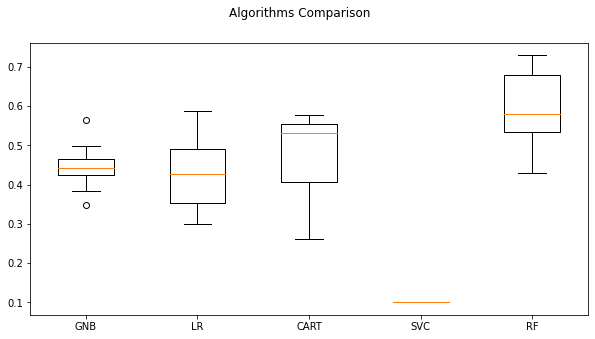

In [117]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [118]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if choosenIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.41      0.87      0.55        30
           1       0.62      0.50      0.56        30
           2       0.67      0.27      0.38        30
           3       0.45      0.30      0.36        30

    accuracy                           0.48       120
   macro avg       0.54      0.48      0.46       120
weighted avg       0.54      0.48      0.46       120

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.45      0.50      0.48        30
           1       0.53      0.57      0.55        30
           2       0.43      0.43      0.43        30
           3       0.44      0.37      0.40        30

    accuracy                           0.47       120
   macro avg       0.46      0.47      0.46       120
weighted avg       0.46      0.47      0.46       120

---------------------------------------------

## Valutazione Inferance Rate medio (|X_test| = 40)

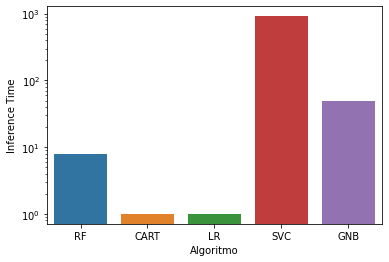

In [119]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

## Memoria occupata

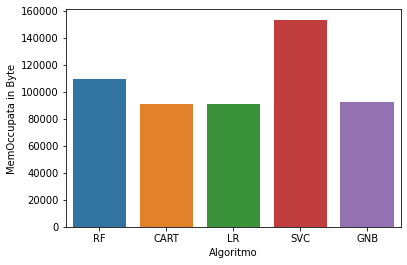

In [120]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [169]:
EPOCHS = 1000 
BATCH_SIZE = 8 if choosenIndex > 1 else 4 #16 with 5 labels
learn_rate = 0.0001
nodes =  512 if choosenIndex > 1 else 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    #model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    #model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [160]:
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 1285      
Total params: 10,789
Trainable params: 10,789
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
135/135 [==============================] - 0s 467us/step - loss: 1.6556 - accuracy: 0.1796
Epoch 2/100

KeyboardInterrupt: 

## Train and Test

In [174]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_85 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_86 (Dense)             (None, 2)                 514       
Total params: 10,018
Trainable params: 10,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
45/45 [==============================] - 0s 2ms/step - loss: 29.1301 - accuracy: 0.5444 - val_loss: 31.5041 - val_accuracy: 0.5333
Epoch 2/1000
45/45 [==============================] - 0s 625us/step - loss: 20.7626 - accuracy: 0.5611 - val_loss: 27.1725 - val_accuracy: 0.5667
Epoch 3/1000
45/45 [==============================] - 0s 608us/step - loss: 17.7250 - acc

Epoch 52/1000
45/45 [==============================] - 0s 609us/step - loss: 0.6715 - accuracy: 0.9389 - val_loss: 11.6926 - val_accuracy: 0.7000
Epoch 53/1000
45/45 [==============================] - 0s 616us/step - loss: 0.2141 - accuracy: 0.9611 - val_loss: 11.4308 - val_accuracy: 0.7167
Epoch 54/1000
45/45 [==============================] - 0s 593us/step - loss: 0.3560 - accuracy: 0.9444 - val_loss: 11.6133 - val_accuracy: 0.7167
Epoch 55/1000
45/45 [==============================] - 0s 594us/step - loss: 0.3692 - accuracy: 0.9500 - val_loss: 11.7141 - val_accuracy: 0.7167
Epoch 56/1000
45/45 [==============================] - 0s 569us/step - loss: 0.3516 - accuracy: 0.9500 - val_loss: 11.6452 - val_accuracy: 0.7333
Epoch 57/1000
45/45 [==============================] - 0s 605us/step - loss: 0.3505 - accuracy: 0.9444 - val_loss: 9.3557 - val_accuracy: 0.7333
Epoch 58/1000
45/45 [==============================] - 0s 623us/step - loss: 0.5321 - accuracy: 0.9278 - val_loss: 11.9306 - 

45/45 [==============================] - 0s 585us/step - loss: 0.0066 - accuracy: 0.9944 - val_loss: 12.2701 - val_accuracy: 0.7167
Epoch 109/1000
45/45 [==============================] - 0s 584us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 12.0401 - val_accuracy: 0.7000
Epoch 110/1000
45/45 [==============================] - 0s 586us/step - loss: 9.7536e-04 - accuracy: 1.0000 - val_loss: 11.9877 - val_accuracy: 0.7000
Epoch 111/1000
45/45 [==============================] - 0s 569us/step - loss: 9.2991e-04 - accuracy: 1.0000 - val_loss: 12.0542 - val_accuracy: 0.7000
Epoch 112/1000
45/45 [==============================] - 0s 599us/step - loss: 7.9157e-04 - accuracy: 1.0000 - val_loss: 12.0052 - val_accuracy: 0.7000
Epoch 113/1000
45/45 [==============================] - 0s 594us/step - loss: 8.8738e-04 - accuracy: 1.0000 - val_loss: 12.0798 - val_accuracy: 0.7000
Epoch 114/1000
45/45 [==============================] - 0s 593us/step - loss: 8.4409e-04 - accuracy: 1.0000 - val_los

45/45 [==============================] - 0s 599us/step - loss: 2.6241e-04 - accuracy: 1.0000 - val_loss: 12.1615 - val_accuracy: 0.7000
Epoch 163/1000
45/45 [==============================] - 0s 599us/step - loss: 2.7936e-04 - accuracy: 1.0000 - val_loss: 12.2080 - val_accuracy: 0.7000
Epoch 164/1000
45/45 [==============================] - 0s 606us/step - loss: 2.6263e-04 - accuracy: 1.0000 - val_loss: 12.1412 - val_accuracy: 0.7000
Epoch 165/1000
45/45 [==============================] - 0s 585us/step - loss: 2.4028e-04 - accuracy: 1.0000 - val_loss: 12.1396 - val_accuracy: 0.7000
Epoch 166/1000
45/45 [==============================] - 0s 598us/step - loss: 2.3367e-04 - accuracy: 1.0000 - val_loss: 12.1210 - val_accuracy: 0.7000
Epoch 167/1000
45/45 [==============================] - 0s 587us/step - loss: 2.3474e-04 - accuracy: 1.0000 - val_loss: 12.1593 - val_accuracy: 0.7000
Epoch 168/1000
45/45 [==============================] - 0s 659us/step - loss: 2.1348e-04 - accuracy: 1.0000 -

45/45 [==============================] - 0s 602us/step - loss: 9.8544e-05 - accuracy: 1.0000 - val_loss: 12.1124 - val_accuracy: 0.7000
Epoch 217/1000
45/45 [==============================] - 0s 581us/step - loss: 9.9404e-05 - accuracy: 1.0000 - val_loss: 12.1115 - val_accuracy: 0.7000
Epoch 218/1000
45/45 [==============================] - 0s 569us/step - loss: 9.6346e-05 - accuracy: 1.0000 - val_loss: 12.1209 - val_accuracy: 0.7000
Epoch 219/1000
45/45 [==============================] - 0s 618us/step - loss: 9.3844e-05 - accuracy: 1.0000 - val_loss: 12.0867 - val_accuracy: 0.7000
Epoch 220/1000
45/45 [==============================] - 0s 584us/step - loss: 9.3460e-05 - accuracy: 1.0000 - val_loss: 12.1790 - val_accuracy: 0.7000
Epoch 221/1000
45/45 [==============================] - 0s 598us/step - loss: 1.0200e-04 - accuracy: 1.0000 - val_loss: 12.0875 - val_accuracy: 0.7000
Epoch 222/1000
45/45 [==============================] - 0s 604us/step - loss: 9.2769e-05 - accuracy: 1.0000 -

45/45 [==============================] - 0s 586us/step - loss: 3.6470e-05 - accuracy: 1.0000 - val_loss: 12.0911 - val_accuracy: 0.7000
Epoch 271/1000
45/45 [==============================] - 0s 599us/step - loss: 4.3444e-05 - accuracy: 1.0000 - val_loss: 12.0193 - val_accuracy: 0.7000
Epoch 272/1000
45/45 [==============================] - 0s 610us/step - loss: 3.8660e-05 - accuracy: 1.0000 - val_loss: 12.0142 - val_accuracy: 0.7000
Epoch 273/1000
45/45 [==============================] - 0s 596us/step - loss: 4.1216e-05 - accuracy: 1.0000 - val_loss: 12.2321 - val_accuracy: 0.7000
Epoch 274/1000
45/45 [==============================] - 0s 590us/step - loss: 5.6938e-05 - accuracy: 1.0000 - val_loss: 11.9422 - val_accuracy: 0.7167
Epoch 275/1000
45/45 [==============================] - 0s 605us/step - loss: 3.8782e-05 - accuracy: 1.0000 - val_loss: 12.0648 - val_accuracy: 0.7000
Epoch 276/1000
45/45 [==============================] - 0s 596us/step - loss: 3.7094e-05 - accuracy: 1.0000 -

45/45 [==============================] - 0s 663us/step - loss: 1.6563e-05 - accuracy: 1.0000 - val_loss: 11.9942 - val_accuracy: 0.7333
Epoch 325/1000
45/45 [==============================] - 0s 632us/step - loss: 2.5260e-05 - accuracy: 1.0000 - val_loss: 11.9959 - val_accuracy: 0.7333
Epoch 326/1000
45/45 [==============================] - 0s 599us/step - loss: 5.7265 - accuracy: 0.8556 - val_loss: 21.5519 - val_accuracy: 0.6500
Epoch 327/1000
45/45 [==============================] - 0s 597us/step - loss: 4.0522 - accuracy: 0.8444 - val_loss: 28.1069 - val_accuracy: 0.6333
Epoch 328/1000
45/45 [==============================] - 0s 603us/step - loss: 13.0913 - accuracy: 0.7111 - val_loss: 21.7396 - val_accuracy: 0.6667
Epoch 329/1000
45/45 [==============================] - 0s 599us/step - loss: 1.5709 - accuracy: 0.8944 - val_loss: 12.7524 - val_accuracy: 0.7500
Epoch 330/1000
45/45 [==============================] - 0s 588us/step - loss: 1.4326 - accuracy: 0.9222 - val_loss: 13.5396 

45/45 [==============================] - 0s 594us/step - loss: 5.6391e-05 - accuracy: 1.0000 - val_loss: 13.9784 - val_accuracy: 0.7167
Epoch 379/1000
45/45 [==============================] - 0s 596us/step - loss: 5.7534e-05 - accuracy: 1.0000 - val_loss: 13.9863 - val_accuracy: 0.7000
Epoch 380/1000
45/45 [==============================] - 0s 601us/step - loss: 5.7177e-05 - accuracy: 1.0000 - val_loss: 13.9845 - val_accuracy: 0.7000
Epoch 381/1000
45/45 [==============================] - 0s 591us/step - loss: 5.6335e-05 - accuracy: 1.0000 - val_loss: 13.9980 - val_accuracy: 0.7000
Epoch 382/1000
45/45 [==============================] - 0s 586us/step - loss: 5.5523e-05 - accuracy: 1.0000 - val_loss: 14.0009 - val_accuracy: 0.7000
Epoch 383/1000
45/45 [==============================] - 0s 592us/step - loss: 5.4588e-05 - accuracy: 1.0000 - val_loss: 13.9951 - val_accuracy: 0.7000
Epoch 384/1000
45/45 [==============================] - 0s 585us/step - loss: 5.3479e-05 - accuracy: 1.0000 -

45/45 [==============================] - 0s 593us/step - loss: 3.3516e-05 - accuracy: 1.0000 - val_loss: 14.1532 - val_accuracy: 0.7000
Epoch 433/1000
45/45 [==============================] - 0s 578us/step - loss: 3.3572e-05 - accuracy: 1.0000 - val_loss: 14.1767 - val_accuracy: 0.7000
Epoch 434/1000
45/45 [==============================] - 0s 599us/step - loss: 3.3247e-05 - accuracy: 1.0000 - val_loss: 14.1725 - val_accuracy: 0.7000
Epoch 435/1000
45/45 [==============================] - 0s 581us/step - loss: 3.2296e-05 - accuracy: 1.0000 - val_loss: 14.1808 - val_accuracy: 0.7000
Epoch 436/1000
45/45 [==============================] - 0s 586us/step - loss: 3.2914e-05 - accuracy: 1.0000 - val_loss: 14.1768 - val_accuracy: 0.7000
Epoch 437/1000
45/45 [==============================] - 0s 599us/step - loss: 3.1660e-05 - accuracy: 1.0000 - val_loss: 14.1863 - val_accuracy: 0.7000
Epoch 438/1000
45/45 [==============================] - 0s 634us/step - loss: 3.2203e-05 - accuracy: 1.0000 -

45/45 [==============================] - 0s 613us/step - loss: 2.1878e-05 - accuracy: 1.0000 - val_loss: 14.3689 - val_accuracy: 0.7000
Epoch 487/1000
45/45 [==============================] - 0s 608us/step - loss: 1.9458e-05 - accuracy: 1.0000 - val_loss: 14.3074 - val_accuracy: 0.7000
Epoch 488/1000
45/45 [==============================] - 0s 591us/step - loss: 1.8563e-05 - accuracy: 1.0000 - val_loss: 14.2968 - val_accuracy: 0.7000
Epoch 489/1000
45/45 [==============================] - 0s 578us/step - loss: 1.8343e-05 - accuracy: 1.0000 - val_loss: 14.3105 - val_accuracy: 0.7000
Epoch 490/1000
45/45 [==============================] - 0s 608us/step - loss: 1.8161e-05 - accuracy: 1.0000 - val_loss: 14.3234 - val_accuracy: 0.7000
Epoch 491/1000
45/45 [==============================] - 0s 595us/step - loss: 1.8546e-05 - accuracy: 1.0000 - val_loss: 14.2873 - val_accuracy: 0.7000
Epoch 492/1000
45/45 [==============================] - 0s 590us/step - loss: 1.9881e-05 - accuracy: 1.0000 -

45/45 [==============================] - 0s 602us/step - loss: 9.0165e-06 - accuracy: 1.0000 - val_loss: 14.2557 - val_accuracy: 0.7000
Epoch 541/1000
45/45 [==============================] - 0s 622us/step - loss: 8.6385e-06 - accuracy: 1.0000 - val_loss: 14.2730 - val_accuracy: 0.6833
Epoch 542/1000
45/45 [==============================] - 0s 614us/step - loss: 9.2171e-06 - accuracy: 1.0000 - val_loss: 14.2719 - val_accuracy: 0.6833
Epoch 543/1000
45/45 [==============================] - 0s 598us/step - loss: 8.6431e-06 - accuracy: 1.0000 - val_loss: 14.2857 - val_accuracy: 0.6833
Epoch 544/1000
45/45 [==============================] - 0s 575us/step - loss: 8.6742e-06 - accuracy: 1.0000 - val_loss: 14.2513 - val_accuracy: 0.7000
Epoch 545/1000
45/45 [==============================] - 0s 593us/step - loss: 8.2100e-06 - accuracy: 1.0000 - val_loss: 14.2052 - val_accuracy: 0.7000
Epoch 546/1000
45/45 [==============================] - 0s 593us/step - loss: 9.0517e-06 - accuracy: 1.0000 -

45/45 [==============================] - 0s 597us/step - loss: 3.8444e-06 - accuracy: 1.0000 - val_loss: 14.1844 - val_accuracy: 0.6833
Epoch 595/1000
45/45 [==============================] - 0s 603us/step - loss: 3.7033e-06 - accuracy: 1.0000 - val_loss: 14.0770 - val_accuracy: 0.7000
Epoch 596/1000
45/45 [==============================] - 0s 613us/step - loss: 3.9715e-06 - accuracy: 1.0000 - val_loss: 14.2081 - val_accuracy: 0.6833
Epoch 597/1000
45/45 [==============================] - 0s 681us/step - loss: 3.5748e-06 - accuracy: 1.0000 - val_loss: 14.1392 - val_accuracy: 0.6833
Epoch 598/1000
45/45 [==============================] - 0s 612us/step - loss: 3.5145e-06 - accuracy: 1.0000 - val_loss: 14.1490 - val_accuracy: 0.6833
Epoch 599/1000
45/45 [==============================] - 0s 589us/step - loss: 3.6112e-06 - accuracy: 1.0000 - val_loss: 14.1929 - val_accuracy: 0.6833
Epoch 600/1000
45/45 [==============================] - 0s 591us/step - loss: 3.3861e-06 - accuracy: 1.0000 -

45/45 [==============================] - 0s 582us/step - loss: 5.4405e-05 - accuracy: 1.0000 - val_loss: 14.5448 - val_accuracy: 0.7667
Epoch 649/1000
45/45 [==============================] - 0s 608us/step - loss: 5.3350e-05 - accuracy: 1.0000 - val_loss: 14.5455 - val_accuracy: 0.7667
Epoch 650/1000
45/45 [==============================] - 0s 584us/step - loss: 5.3692e-05 - accuracy: 1.0000 - val_loss: 14.5429 - val_accuracy: 0.7667
Epoch 651/1000
45/45 [==============================] - 0s 587us/step - loss: 5.2871e-05 - accuracy: 1.0000 - val_loss: 14.5403 - val_accuracy: 0.7667
Epoch 652/1000
45/45 [==============================] - 0s 580us/step - loss: 5.1813e-05 - accuracy: 1.0000 - val_loss: 14.5431 - val_accuracy: 0.7667
Epoch 653/1000
45/45 [==============================] - 0s 589us/step - loss: 5.1497e-05 - accuracy: 1.0000 - val_loss: 14.5420 - val_accuracy: 0.7667
Epoch 654/1000
45/45 [==============================] - 0s 599us/step - loss: 5.0758e-05 - accuracy: 1.0000 -

45/45 [==============================] - 0s 598us/step - loss: 2.9406e-05 - accuracy: 1.0000 - val_loss: 14.5470 - val_accuracy: 0.7667
Epoch 703/1000
45/45 [==============================] - 0s 597us/step - loss: 2.9152e-05 - accuracy: 1.0000 - val_loss: 14.5460 - val_accuracy: 0.7667
Epoch 704/1000
45/45 [==============================] - 0s 584us/step - loss: 2.9187e-05 - accuracy: 1.0000 - val_loss: 14.5474 - val_accuracy: 0.7667
Epoch 705/1000
45/45 [==============================] - 0s 602us/step - loss: 2.9369e-05 - accuracy: 1.0000 - val_loss: 14.5529 - val_accuracy: 0.7667
Epoch 706/1000
45/45 [==============================] - 0s 617us/step - loss: 2.8481e-05 - accuracy: 1.0000 - val_loss: 14.5549 - val_accuracy: 0.7667
Epoch 707/1000
45/45 [==============================] - 0s 590us/step - loss: 2.7622e-05 - accuracy: 1.0000 - val_loss: 14.5425 - val_accuracy: 0.7667
Epoch 708/1000
45/45 [==============================] - 0s 605us/step - loss: 2.6954e-05 - accuracy: 1.0000 -

45/45 [==============================] - 0s 592us/step - loss: 1.4645e-05 - accuracy: 1.0000 - val_loss: 14.5877 - val_accuracy: 0.7667
Epoch 757/1000
45/45 [==============================] - 0s 626us/step - loss: 1.3884e-05 - accuracy: 1.0000 - val_loss: 14.5845 - val_accuracy: 0.7667
Epoch 758/1000
45/45 [==============================] - 0s 601us/step - loss: 1.3253e-05 - accuracy: 1.0000 - val_loss: 14.5930 - val_accuracy: 0.7667
Epoch 759/1000
45/45 [==============================] - 0s 591us/step - loss: 1.3593e-05 - accuracy: 1.0000 - val_loss: 14.5837 - val_accuracy: 0.7667
Epoch 760/1000
45/45 [==============================] - 0s 578us/step - loss: 1.3379e-05 - accuracy: 1.0000 - val_loss: 14.5960 - val_accuracy: 0.7667
Epoch 761/1000
45/45 [==============================] - 0s 602us/step - loss: 1.2832e-05 - accuracy: 1.0000 - val_loss: 14.5970 - val_accuracy: 0.7667
Epoch 762/1000
45/45 [==============================] - 0s 575us/step - loss: 1.2732e-05 - accuracy: 1.0000 -

45/45 [==============================] - 0s 630us/step - loss: 6.3498e-06 - accuracy: 1.0000 - val_loss: 14.5649 - val_accuracy: 0.7667
Epoch 811/1000
45/45 [==============================] - 0s 616us/step - loss: 5.8215e-06 - accuracy: 1.0000 - val_loss: 14.5818 - val_accuracy: 0.7667
Epoch 812/1000
45/45 [==============================] - 0s 587us/step - loss: 5.8261e-06 - accuracy: 1.0000 - val_loss: 14.5742 - val_accuracy: 0.7667
Epoch 813/1000
45/45 [==============================] - 0s 603us/step - loss: 6.0941e-06 - accuracy: 1.0000 - val_loss: 14.5882 - val_accuracy: 0.7667
Epoch 814/1000
45/45 [==============================] - 0s 596us/step - loss: 6.6836e-06 - accuracy: 1.0000 - val_loss: 14.5636 - val_accuracy: 0.7667
Epoch 815/1000
45/45 [==============================] - 0s 616us/step - loss: 6.3458e-06 - accuracy: 1.0000 - val_loss: 14.5643 - val_accuracy: 0.7500
Epoch 816/1000
45/45 [==============================] - 0s 588us/step - loss: 5.7552e-06 - accuracy: 1.0000 -

45/45 [==============================] - 0s 583us/step - loss: 2.3656e-06 - accuracy: 1.0000 - val_loss: 14.4807 - val_accuracy: 0.7333
Epoch 865/1000
45/45 [==============================] - 0s 600us/step - loss: 2.2821e-06 - accuracy: 1.0000 - val_loss: 14.5152 - val_accuracy: 0.7333
Epoch 866/1000
45/45 [==============================] - 0s 598us/step - loss: 2.2344e-06 - accuracy: 1.0000 - val_loss: 14.5131 - val_accuracy: 0.7333
Epoch 867/1000
45/45 [==============================] - 0s 606us/step - loss: 2.1298e-06 - accuracy: 1.0000 - val_loss: 14.5043 - val_accuracy: 0.7333
Epoch 868/1000
45/45 [==============================] - 0s 586us/step - loss: 2.1397e-06 - accuracy: 1.0000 - val_loss: 14.5127 - val_accuracy: 0.7333
Epoch 869/1000
45/45 [==============================] - 0s 596us/step - loss: 2.0543e-06 - accuracy: 1.0000 - val_loss: 14.5066 - val_accuracy: 0.7333
Epoch 870/1000
45/45 [==============================] - 0s 726us/step - loss: 2.0834e-06 - accuracy: 1.0000 -

45/45 [==============================] - 0s 597us/step - loss: 9.0532e-07 - accuracy: 1.0000 - val_loss: 14.3827 - val_accuracy: 0.7333
Epoch 919/1000
45/45 [==============================] - 0s 593us/step - loss: 9.0863e-07 - accuracy: 1.0000 - val_loss: 14.3534 - val_accuracy: 0.7333
Epoch 920/1000
45/45 [==============================] - 0s 596us/step - loss: 8.7022e-07 - accuracy: 1.0000 - val_loss: 14.3595 - val_accuracy: 0.7333
Epoch 921/1000
45/45 [==============================] - 0s 604us/step - loss: 8.9207e-07 - accuracy: 1.0000 - val_loss: 14.3325 - val_accuracy: 0.7333
Epoch 922/1000
45/45 [==============================] - 0s 590us/step - loss: 8.8214e-07 - accuracy: 1.0000 - val_loss: 14.3174 - val_accuracy: 0.7333
Epoch 923/1000
45/45 [==============================] - 0s 605us/step - loss: 8.9671e-07 - accuracy: 1.0000 - val_loss: 14.3588 - val_accuracy: 0.7333
Epoch 924/1000
45/45 [==============================] - 0s 603us/step - loss: 8.0863e-07 - accuracy: 1.0000 -

45/45 [==============================] - 0s 588us/step - loss: 3.9471e-07 - accuracy: 1.0000 - val_loss: 14.2146 - val_accuracy: 0.7333
Epoch 973/1000
45/45 [==============================] - 0s 604us/step - loss: 3.9339e-07 - accuracy: 1.0000 - val_loss: 14.1255 - val_accuracy: 0.7333
Epoch 974/1000
45/45 [==============================] - 0s 624us/step - loss: 3.3975e-07 - accuracy: 1.0000 - val_loss: 14.1168 - val_accuracy: 0.7333
Epoch 975/1000
45/45 [==============================] - 0s 604us/step - loss: 3.6491e-07 - accuracy: 1.0000 - val_loss: 14.1239 - val_accuracy: 0.7333
Epoch 976/1000
45/45 [==============================] - 0s 586us/step - loss: 3.4239e-07 - accuracy: 1.0000 - val_loss: 14.1311 - val_accuracy: 0.7333
Epoch 977/1000
45/45 [==============================] - 0s 582us/step - loss: 3.2981e-07 - accuracy: 1.0000 - val_loss: 14.1376 - val_accuracy: 0.7333
Epoch 978/1000
45/45 [==============================] - 0s 582us/step - loss: 3.5299e-07 - accuracy: 1.0000 -

In [175]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.69      0.83      0.76        30
           1       0.79      0.63      0.70        30

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



# Export Models in C code

In [136]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmp5aw55c9c/assets


INFO:tensorflow:Assets written to: /tmp/tmp5aw55c9c/assets
